# 들어가기 앞서

`RetinaNet`리뷰에 앞서 Object Detection의 개념에 대해 간단히 짚고 넘어가자.  

RetianNet은 Object Detection 알고리즘 중  `1-stage-Detector`에 해당한다. Object Detection의 모델은 이미지 내의 객체의 영역을 찾아내고 __IOU(Intersection over Union)__ threshold에 따라 positive/negative sample로 나눈 뒤 학습한다.  

여기서 __class imbalance__ 의 문제가 발생한다. 이미지 내에 positive sample(객체)와 negative sample(배경) 사이의 차이가 크기 때문이다. 배경 영역 때문에 대부분 sample이 easy negative가 되고, 그 easy negative의 수가 압도적으로 많아서 학습에 끼치는 영향력이 커 모델의 성능이 하락하게 된다.  

2-stage-detector는 이러한 문제를 해결하기 위해 두 가지 측면에서 해결책을 썼다.  
- region proposals을 통해 negative sample을 filtering  
    * selective search, edge boxex, deepmask , RPN 등  
- positive/negative sample의 수를 적절하기 유지하는 sampling heuristic 방법  
    * hard negative mining, OHEM 등  
    
1-stage-detector 계열의 문제점은 위에서 언급한 class imbalance의 문제를 해결하기에 부적절했다. region proposal 과정을 없애고 이미지 전체를 sampling하는 dense sampling 방법을 수행하기 때문에, 더 많은 후보영역이 발생하고 class imbalance 문제가 더 심각하다.  

따라서 1-stage-detector는 2-stage-detector보다 속도는 빠르지만 성능은 떨어진다는 단점이 있었다.  

해당 논문은 class imbalance의 문제를 main으로 보고 __focal loss__ 를 통한 해결 방법을 제시하였고, 2-stage-detector보다 더 좋은 성능까지 입증한다.

# 0. Abstarct

Object Detection에서 상대적으로 2-stage-detector가 정확도 측면에서 좋은 퍼포먼스를 보였다면 1-stage-detector은 속도 측면에서 좋은 퍼포먼스를 보였다. 각각 정확도와 속도간에 trade-off 관계가 있지만, 1-stage-detector 분야에서 SOTA 모델들이 파생되어 개발되고 있다.  
Object Detection의 고질적인 문제인 class imbalance 문제를 해결하고 빠르고 정확한 객체 탐지를 위한 2-stage-dector의 정확도를 능가하면서 1-stage-detector의 속도와 버금가는 __`RetinaNet`__ 을 개발하였다.

# 1. Introduction

당시 sota 성능의 object detectors는 R-CNN계열의 detector들과 같은 2-stage detector였다. 물론 YOLO와 SSD와 같은 1-stage detector들이 유망한 결과를 보여줬지만, 정확도 성능은 낮았다. 본 논문에서는 1-stage detector가 Faster R-CNN의 변형(FPN, Mask R-CNN,...)등과 같은 2-stage detector와 같은 성능을 얻기 위해 1-stage detector의 sota accuract를 방해하는 class imabalance를 확인했고, 이를 해결하기 위해 새로운 loss function을 제안했다.

R-CNN과 같은 2-stage detector의 경우 proposal stage(e.g., Selective Search, RPN,...)에서 background sample들을 필터링 하고, 분류 단계에서 sampling heuristics(fixed foreground-to-background ratio(1:3)과 OHEM)을 통해 foreground와 background의 균형을 유지한다. 이와 다르게 1-stage detector들의 경우 엄청나게 많은 객체 위치 후보들(~100k locations)을 처리해야한다. 물론 sampling heuristics를 적용할 수 있으나 학습시 비효율적이다.

본 논문에서는 class imbalance를 다루기 위한 새로운 loss function인 __focal loss__를 제안한다. 이는 dynamically scaled cross entropy loss로 scaling factor를 이용해 easy example의 경우 down-weight하고, hard example들에 집중하게 한다. 제안된 focal loss의 효율성을 보여주기 위해 ResNet-101-FPN backbone을 기본으로하는 RetinaNet을 제안한다. 해당 모델은 기존의 1-stage, 2-stage detector들의 성능을 능가한다.

# 2. Related Work

### Classic Object Detector

image grid에 분류기가 적용되는 window sliding 기법은 아주 긴 역사를 가진다. 초기 성공 사례 중 하나는 손으로 쓴 숫자 인식에 convolution 신경망을 적용한 __LeCun__ 등의 고전적인 연구이다. 또한, 얼굴 감지를 위해 Boosted detector를 사용하였고, 이러한 모델이 널리 채택되었다. windwo sliding 방법이 고전적 컴퓨터 비전에서는 선도적인 검출 패러다임이었지만 딥러닝이 부활하면서 그 다음으로 설명되는 2-stage-dector는 빠르게 객체 탐지를 지배하게 되었다.

### Two-stage Detectors

현대 Object Detection에서 지배적인 패러다임은 2-stage 접근법에 기초한다. `Selective Search`와 같이, 첫 번째 단계는 regional proposal을 통해 대부분 negative sample들을 filtering 하면서 모든 객체를 포함해야 하는 sparse set을 생성하고, 두 번째 단계에서 resional proposal을 통해 object가 있을 법한 영역을 뽑아낸 RoI를 통해 해당 sparse set들을 foreground class/background로 분류한다. 대표적인 2-stage detector로 `R-CNN`이 있다.

### One-stage Detectors

영역 탐지와 분류를 한 번에 수행하는 1-stage detector는 어느정도의 정확도 손실을 감수하고 속도에서의 좋은 퍼포먼스를 보인다. 가장 대표적인 `YOLO`는 1-stage detector 에서 어느정도 좋은 정확도를 보이고 빠른 속도로 객체를 탐지한다. 

### Class Imbalance

Boosted detector와 DPM과 같은 기존의 객체 탐지 방법과 SSD와 같은 최신 방법 모두 학습 중에 큰 __class imbalance__ 를 직면한다. 이러한 detector는 이미지당 104-105의 후보 위치를 평가하지만, 일부 위치에만 positive(객체)가 포함되어 있다. 이러한 불균형은 두 가지 문제를 야기한다.  
- 대부분의 sample이 객체를 포함하지 않는 negative sample이기 때문에 학습이 비효율적  
- negative sampe(배경)이 sample들의 대부분을 차지하여 모델의 성능이 현저히 낮아질 수 있음  

일반적인 해결책은 학습 또는 더 복잡한 표본 추출 중 __`hard negative mining`__ 을 수행하는 것이다.  

#### hard negative mining
hard negative : 실제로는 negative인데 positive라고 잘못 예측하기 쉬운 데이터  
easy negative : 실제로 negative이고 예측도 negative라고 잘 나오는 데이터  

2-stage 모델을 활용한 object detection task 시, region proposals를 기반으로 classification과 localization을 수행한다.. 하지만 일반적으로 이미지 내 객체가 존재하는 영역보다 객체가 존재하지 않는 영역이 훨씬 많기 때문에 추출되는 region proposals에는 객체가 있는 영역(foreground)보다 배경 영역(background)이 더 많다. 이로 인해 클래스 불균형(class imbalance) 문제가 발생하여 모델의 학습이 제대로 이뤄지지 않을 수 있다. 이러한 문제를 해결하기 기존에는 Hard Negative Mining 방법을 사용했습니다.  

Hard Negative Mining은 모델이 잘못 예측한, 어려운(hard) sample을 추출하는 방법이다. 가령 object detection 모델이 있다고 할 때, positive sample은 객체에 해당하는 영역이며, negative sample은 배경이다. 여기서 모델이 예측하기 어려운 sample은 주로 False Positive sample(객체라고 예측했지만 실제는 배경인 samplie)이다. 왜냐하면 object detection 모델은 positive에 해당하는 객체의 영역만을 detect하기 때문에, 배경을 잘못 예측한 False Negative sample은 object detection task에서 고려하지 않기 때문이다.  

기존에는 Hard Negative Mining을 사용하여 모델이 예측하기 어려운 sample을 추출한 후, 학습 데이터에 포함시켜 모델이 __False Positive 오류(배경을 객체로 잘못 예측하는 오류)__ 에 강건해지도록 학습시켰습니다. Object detection 모델 학습에 Hard Negative Mining 방법을 적용할 경우 다음과 같이 동작합니다.  

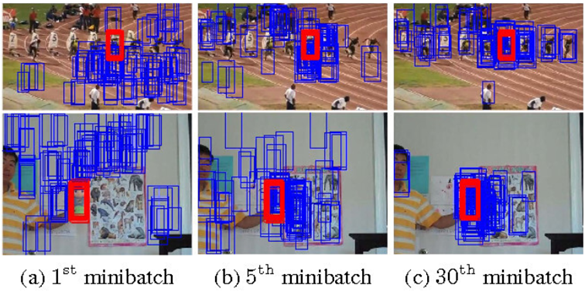  

전체 region proposals 중에서 positive/negative sample을 적절히 섞어 mini-batch로 구성한 후 모델에 입력하여 모델을 학습시킨다. Hard Negative Mining 방법을 적용하여 학습된 모델이 False Positive로 판단한 sample을 학습 데이터셋에 추가한다. 다음 epoch부터 모델은 False Positive sample이 추가된 mini-batch를 입력받아 학습하며, 마지막 epoch까지 위의 과정을 반복한다.  

위의 그림에서 빨간색 box는 positive sample, 파란색 box는 negative sample이다. 학습이 거듭될수록 점차 mini-batch에 False Positive sample들이 더해지면서 객체라고 착각할만큼 어려운 negative sample들이 추가된 것을 확인할 수 있다.  
정리하면 배경을 객체로 잘못 예측하는, detector가 예측하기 어려운 False Positive 데이터를 추가하여 detector의 객체 탐지 성능 향상을 기대한다.

### Robust Estimation

loss가 큰 예 들의 loss를 줄이고 특이치의 기여도를 중리는 강력한 손실 함수를 설계하는데 많은 관심이 있어 왔다. 이와 대조적으로, 본 논문의 __focal loss__ 는 특이치를 다루기 보다는 전체 loss에 대한 기여도가 크면 전체가 작아지도록 inlier를 down-weighting하여 class imbalance를 해결하도록 설계하였다.

# 3. Focal Loss

Focal loss는 학습하면서 foreground와 background 사이의 큰 imbalance 문제를 해결하도록 1-stage에서 설계되었다.  

이진 분류를 위한 cross entropy(CE) loss는 다음과 같다.  
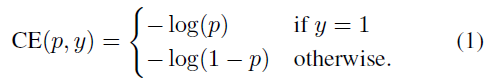  

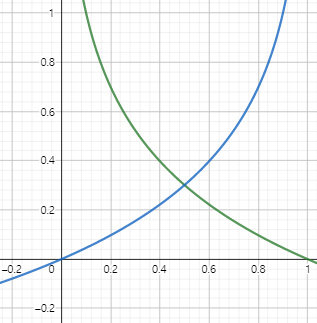

$y ∈ [1, -1]$는 ground truth class를 나타내고, $p ∈ [0,1]$ : 모델이 예상한 클래스가 $y = 1$일 확률을 나타낸다.  
표기의 편의성을 위해 $p_t$를 다음과 같이 정의한다.  

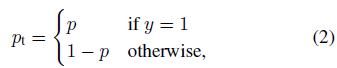  

위의 log 함수 그래프를 보며 각 상황별 loss가 어떻게 변하는지 알아보자.  
초록선이 $-log(p)$, 파란선이 $-log(1-p)$를 나타낸다.  
초록선의 경우($y=1$인 경우) 모델이 예상한 클래스가 $y=1$일 확률이 커질수록(1에 가까워 질수록) CE loss가 감소한다.  
반대로 파란선의 경우(otherwise인 경우) 모델이 예상한 클래스가 $y=-1$일 확률이 커질수록(1에 가까워질수록) CE loss가 증가한다.



따라서 간편하게 바꿔보면 $CE(p,y) = CE(p_t) = -log(p_t)$로 나타낼 수 있다.

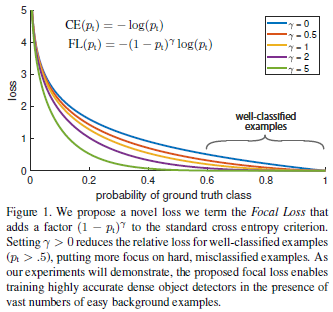

__< Figure 1 >__ 에서 파란색 선($\gamma = 0$)은 $CE$를 나타낸다. 해당 선을 통해 y에 상관없이 $CE$가 쉽게 분류 가능한 ($p_t >> .5$) example들에 대해서도 non-trivial한 정도의 loss를 갖는다는 것을 확인할 수 있다. 많은 수의 easy example들이 합해졌을 때, 작은 loss 값들이 rare class를 압도할 수 있다.  

CE loss의 문제점은 모든 sample에 대한 예측 결과를 동등하게 가중치를 둔다는 점이다. 이로 인해 어떠한 sample이 쉽게 분류될 수 있음에도 불구하고 작지 않은 loss를 유발한다. 많은 수의 easy example의 loss가 더해지면 보기 드문 class를 압도해버려 학습이 제대로 이뤄지지 않는다.

## (1) Balanced Cross Entropy

이러한 문제를 해결하기 위해 가중치 파라미터인 $\alpha ∈ [0,1]$를 곱해준 __Balanced Cross Entropy__ 가 등장한다.  

$$ CE(p_t) = -\alpha_t log(p_t)$$  

$y=1$일 때 $\alpha$를 곱해주고, $y=-1$일 때 $1-\alpha$를 곱해준다.  
이러한 weight factor로 positive와 negative sample들 사이의 균형을 잡아주지만, easy/hard sample에 대해서는 균형을 잡지 못한다.  
이 부분을 해결한 것이 __Scaling Factor__ 이고, Scaling Factor가 추가된 것이 __Focal Loss function__ 이다.

## (2) Focal Loss Definition

쉽게 분류되는 negative의 loss는 전체 loss의 대부분을 차지하고, gradient를 거의 지배한다. $\alpha$ balance parameter는 positive/negative에겐 영향을 주지만, easy(TN)과 hard(FP) example 사이를 구별짓지는 못한다고 언급하였다.  

따라서 CE에 modulating factor인 $(1-p_t)^{\gamma}$를 곱해 factor에 추가로 변화를 주었다.  
여기서 $\gamma$는 조정할 수 있는 파라미터이다. $\gamma ∈ [0,5]$  

$$FL(p_t)=\begin{cases}
-(1-p_t)^{\gamma}log(p_t),\;\;\;\;\;\;\;\;\;\;if\;y=1 \\
-(1-(1-p_t))^{\gamma}log(p_t),\;\;otherwise\end{cases}$$  

__`Focal Loss`__ 는 easy example을 down-weight하여 hard negative sample에 집중하여 학습하는 loss function이다. 

앞서 __< Figure 1 >__ 에서 확인했듯, 파란색 선($CE(p_t)$)는 경사가 완만하여 $p_t$가 높은 example과 낮은 example 사이의 차이가 크지 않다는 것을 알 수 있다.  
반면 파란선 외의 __Focal Loss__ 의 경우 focusing parameter $\gamma$에 따라 $p_t$가 높은 example과 낮은 example 사이의 차이가 상대적으로 크다는 것을 알 수 있다.  

즉, $y=1$인 class임에도 $p_t$가 낮은 경우와, $y=-1$임에도 $p_t$가 높은 경우에 Focal Loss가 높다. 반대의 경우에는 down-weight되어 loss값이 낮게 나타난다. 이를 통해 Focal Loss의 두 가지 특성을 확인할 수 있다.

### 1) $p_t$와 modulating factor와의 관계

exmaple이 잘못 분류되고, $p_t$가 작으면, modulating factor는 1과 가까워지며, loss는 영향을 받지 않는다. 반대로 $p_t$값이 크면 modulating factor는 0에 가까워지고, 잘 분류된 example의 loss는 down-weight된다.

### 2) focusing parameter $\gamma$의 역할

focusing parameter $\gamma$는 easy example을 donw-weight하는 정도를 부드럽게 조정한다. $\gamma = 0$인 경우, Focal Loss는 CE와 같으며, $\gamma$가 상승할수록 modulating factor의 영향력이 커지게 된다. 논문에서는 실섬 시 $\gamma = 2$일 때 가장 좋은 결과를 보였다. modulating factor는 easy example의 기여도를 줄이고, example이 작은 loss를 받는 범위를 확장시키는 기능을 한다.  

예를 들어 $\gamma = 2, p_t = 0.9$일 때, CE에 비해 100배 적은 loss를 가지며 $p_t = 0.968$일 때는 1000배 적은 loss를 가진다.  
이는 잘못 분류된 example을 수정하는 작업의 중요도를 상승시킴을 의미한다.

# 4. RetinaNet Detector

 RetinaNet은 ResNet-FPN을 backnone으로 하여 2개의 sub-network를 사용하는 신경망이다. 첫 번째 sub-network는 object classification을 수행하고, 두 번째 sub-network는 bounding box regression을 수행한다. 전체적인 구조는 아래 그림과 같다.

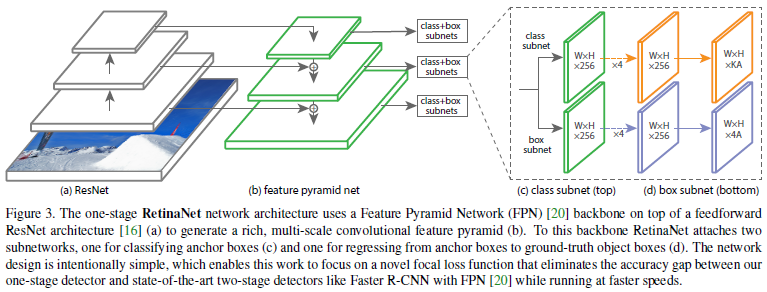

### (1) Feature Pyramid Network Backbone

먼저 이미지를 backbone network에 입력하여 서로 다른 5개의 scale을 가진 feature pyramid를 출력한다. backbone은 전체 input image에 대한 convolution feature map의 연산을 하는 기능을 한다. backbone은 자체 convolution network이다. 추가적인 설명은 추후에 포스팅하겠다.  

여기서 backbone network는 ResNet 기반의 __FPN(Feature Pyramid Network)__ 를 사용한다.  
FPN은 하나의 input image에 대해 multi-scale feature pyramid를 생성한다. 각 레벨의 pyramid는 다른 scale에서 object를 detect하는데 사용한다. 작은 크기의 object부터 큰 크기의 object까지 다양한 scale을 가지는 object의 detect 능력이 향상된다. ResNet 자체만 사용했을 때는 AP가 낮아서 ResNet 상단에 FPN을 적용한다. pyramid는 level P3 ~ P7을 사용했고, pyramid의 channels의 수는 256이다.  

* __Input__ : image  
* __Process__ : feature extraction by ResNet + FPN  
* __Output__ : feature pyramid(P5~P7)

### (2) Anchors

각 pyramid level에 aspect ratio = {1:2, 1:1, 2:1}, size = {$2^0, 2^{1/3}, 2^{2/3}$}을 사용하여 총 9개의 anchor를 할당한다. 각 Anchor은 one-hot K vector(K 개의 class중 해당하는 class는 1, 나머지는 0)와 Bounding Box offset 4개를 할당한다. 따라서 하나의 Anchor에는 Kx4의 vector가 할당된다.  

Anchor은 IoU가 0.5 이상인 ground-truth에 할당한다. IoU가 0 ~ 0.4이면 background 라고 판단한다. 0.4 ~ 0.5 IoU를 가진 anchor은 학습 도중에 무시한다.

### (3) Classification Subnet

(1) 과정에서 얻은 각 pyramid level별 feature map을 Classification subnetwork에 입력한다.  
해당 subnet는 3x3(xC) conv layer - ReLU - 3x3(xKxA) conv layer로 구성되어 있다. 여기서 __K__ 는 분류하고자 하는 class의 수를, __A__ 는 anchor box의 수를 의미한다. 논문에서는 __A=9__ 로 설정한다. 그리고 마지막으로 얻은 feature map의 각 spatial location(feature map의 cell)마다 sigmoid activation function을 적용한다. 이를 통해 channel 수가 KxA인 5개(feature pyramid의 수)의 feature map을 얻을 수 있다. Subnet의 parameter들은 모든 pyramid level들에서 공유된다. 

* __Input__ : feature pyramid(P5~P7) 
* __Process__ : classification by classification subnetwork
* __Output__ : 5 feature maps with KxA channel(Focal Loss 적용)

### (4) Box Regression Subnet

(1) 과정에서 얻은 각 pyramid level별 feature map을 Bounding box regression subnetwork에 입력한다. 해당 subnet 역시 classification subnet과 마찬가지로 FCN(Fully Convolutional Network)이다. feature map이 anchor box별로 4개의 좌표값(x, y, w, h)을 encode하도록 channel 수를 조정한다. 최종적으로 channel 수가 4xA인 5개의 feature map을 얻을 수 있다.  
classfication subnet과의 차이점은 파라미터 수가 적고 class 정보 없이 anchor box를 regression한다. classification subnet과 box regression subnet은 구조는 같지만 개별적인 파라미터를 사용한다. 즉, 파라미터 공유가 일어나지 않는다. 

* __Input__ : feature pyramid(P5~P7)
* __Process__ : bounding box regression by bounding box regression subnet
* __Output__ : 5 feature maps with 4xA channel

## 4.1. Inference and Training

### Inference

Inference는 사진 3에 나와있는 네트워크 구조에 따라 image를 처리한다. 속도를 개선하기 위해 FPN level마다 1k top-scoring 예측들의 box prediction만 decode한다. 여기서 decode란 relative offset을 ground-truth 좌표로 바꾸는 과정을 말한다. 이후 이들을 합친 후 0.5의 threshold로 nms(non-maximum-suppression)를 수행해서 최종 detection 결과를 얻는다.

### Focal Loss

Focal loss는 classification subnet의 출력에 적용된다. 논문의 저자들은 실험을 통해 $\gamma=2, \alpha=0.25$로 정했다. Total focal loss는 ~100k anchors의 focal loss의 합으로 계산되고, ground-truth box로 할당된 anchor box들의 개수로 normalized 된다. 이때 모든 anchor box로 normalized 하지 않은 이유는 대부분의 anchor들이 easy negative들이고 사소한(매우 작은) loss를 갖기 때문이다.

### Initialization

Backbone이 되는 ResNet-50과 ResNet-101은 ImageNet1k dataset을 이용해 pretrain된 모델을 사용한다. 마지막 conv layer를 제외한 모든 conv layer들은 bias는 b=0, weight는 $\sigma$=0.01인 Gaussian 분포로 초기화 된다. Classification subnet의 마지막 conv layer의 bias b=−log((1−π)/π)로 ~π의 confidence로 모든 anchor들은 foreground로 labeled된다. 실험에서 π=.01을 사용했다. 이러한 초기화 방법은 많은 양의 background anchor들에 인한 학습 초기 불안정을 막아준다.